# Описание проекта

Вы работаете в интернет-магазине, который продаёт по всему миру компьютерные игры.
Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и
платформы (например, Xbox или PlayStation).  

Вам нужно выявить определяющие успешность игры закономерности.  
Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й.
Нужно отработать принцип работы с данными.

__Описание данных__  
	`Name` — название игры  
	`Platform` — платформа  
	`Year_of_Release` — год выпуска  
	`Genre` — жанр игры  
	`NA_sales` — продажи в Северной Америке (миллионы долларов)  
	`EU_sales` — продажи в Европе (миллионы долларов)  
	`JP_sales` — продажи в Японии (миллионы долларов)  
	`Other_sales` — продажи в других странах (миллионы долларов)  
	`Critic_Score` — оценка критиков (максимум 100)  
	`User_Score` — оценка пользователей (максимум 10)  
	`Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board).	Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.


# Шаг 1. Открытие файла с данными и изучение общей информации

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('/datasets/games.csv')

df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [2]:
# приведение названия столбцов к нижнему регистру

df.columns = df.columns.str.lower()
df['sales_all'] = df['na_sales'] + df['eu_sales'] +df['jp_sales'] + df['other_sales']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 12 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
sales_all          16715 non-null float64
dtypes: float64(7), object(5)
memory usage: 1.5+ MB


# Шаг 2. Подготовка данных

#### Обработка пропусков

In [3]:
df.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
sales_all             0
dtype: int64

In [4]:
#Обработка пропусков в name

df[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_all
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN,2.39
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN,0.03


Примечательно, что в этих же записях существуют и пропуски поля genre (жанр).  

Названия игр в нашем анализе не так важно, в отличие от всех остальдных данных.  
Частично эти данные есть в этих записях и мы можем их использовать для некоторых видов анализа. Поэтому можем заполнить пропуски нейтральным значением Noname.  

Поле genre мы используем в нашем исследовании, но, к сожалению, заполнить пропуски в этом поле не представляется возможным. Поэтому в дальнейших исследованиях с полем genre эти записи будем исключать.

In [5]:
df.name = df.name.fillna('Noname')

In [6]:
# обработка поля year_of_release

df[df['year_of_release'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_all
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E,5.24
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E,3.50
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+,3.06
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN,3.00
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN,2.53


Не понятно, почему в этих случаях пропущен год релиза, но в некоторых играх мы видим год в названии игры. Мы можем выявить этот год и подставить в поле "год релиза".  

Прочие игры без года выпуска удалять не будем, мы используем данные о продажах из этих записей в дальнейшем анализе.

In [7]:
df[(df['year_of_release'].isna()) & (df.name.str.contains(r'\d{4}', regex=True, na=False))].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_all
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E,5.24
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E,3.50
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN,3.00
1650,NASCAR Thunder 2003,PS2,NaN,Racing,0.60,0.46,0.00,0.16,84.0,8.7,E,1.22
2572,PES 2009: Pro Evolution Soccer,PSP,NaN,Sports,0.04,0.33,0.26,0.17,NaN,NaN,NaN,0.80


In [8]:
import re

ss = df[(df['year_of_release'].isna()) & (df.name.str.contains(r'\d{4}', regex=True, na=False))].index

def fill_year(row):
    if pd.isna(row['year_of_release']):
        if re.findall(r'\d{4}', row['name']):
            return re.findall(r'\d{4}', row['name'])[0]
        else:
            return 0
    return row['year_of_release']

df['year_of_release'] = df.apply(fill_year, axis=1)

In [9]:
df[df.index.isin(ss)].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_all
183,Madden NFL 2004,PS2,2004,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E,5.24
377,FIFA Soccer 2004,PS2,2004,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E,3.50
475,wwe Smackdown vs. Raw 2006,PS2,2006,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN,3.00
1650,NASCAR Thunder 2003,PS2,2003,Racing,0.60,0.46,0.00,0.16,84.0,8.7,E,1.22
2572,PES 2009: Pro Evolution Soccer,PSP,2009,Sports,0.04,0.33,0.26,0.17,NaN,NaN,NaN,0.80


In [10]:
df.year_of_release = df.year_of_release.astype('int')
df = df.sort_values(by=['platform', 'year_of_release'])

In [11]:
isna = df.isna().sum().to_frame()
isna.columns = ['isna']
isna['dtypes'] = df.dtypes
isna.T

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_all
isna,0,0,0,2,0,0,0,0,8578,6701,6766,0
dtypes,object,object,int64,object,float64,float64,float64,float64,float64,object,object,float64


Пропуски в последних трех полях объясняется тем, что не все игры были оценены экспертами и игроками.  
Соответственно, пропуски в этих полях заполнять не будем, но эти записи будем иссключать из исследований, которые будут касаться значений в этих полях.  

В поле user_score встречается значение TBD (ToBeDetermine), то есть "Будет определено". Т.е. это тоже не определенное значение. 

In [12]:
# суммарные продажи по регионам

sales_all = df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum()
sales_all

na_sales       4402.35
eu_sales       2424.67
jp_sales       1297.37
other_sales     791.32
dtype: float64

# Шаг 3.  Исследовательский анализ данных

### Сколько игр выпускалось в разные годы

In [13]:
#предварительно установим опции для вывода на экран всех строк и колонок
pd.set_option('display.max_rows', None, 'display.max_columns', None)

In [14]:
# life_of_platform - таблица "жизни" платформ

life_of_platform = (
    df
    .query('year_of_release > 0')
    .pivot_table(index=['year_of_release'], columns='platform', values='sales_all', aggfunc='count')
)
for idx in life_of_platform.index:
    for col in life_of_platform.columns:
        if not pd.isna(life_of_platform.loc[idx, col]):
            life_of_platform.loc[idx, col] = idx
        

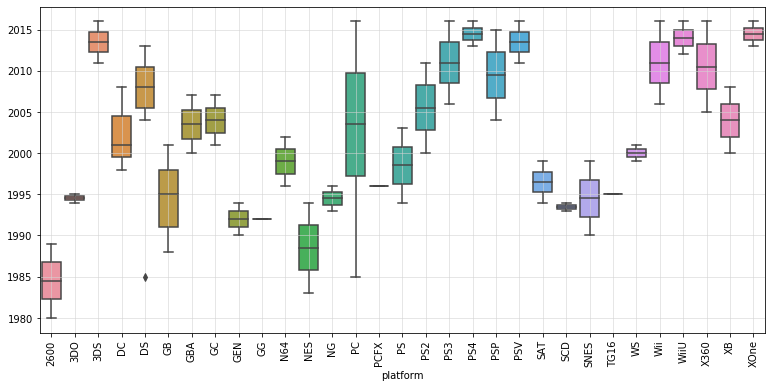

In [15]:
# график сроков "жизни" платформ
import seaborn as sns
plt.figure(figsize=(13, 6))
boxplt = sns.boxplot(data=life_of_platform)
boxplt.grid(color='lightgray', alpha=0.7)
boxplt.tick_params(axis='x', rotation=90)
plt.show()


In [16]:
# platforms_count_games - таблица с количеством реализованных игр по платформам и годам релиза
platforms_count_games = (
    df
    .query('year_of_release > 0')
    .pivot_table(index='year_of_release', columns='platform', 
                 values='name', aggfunc='count')
)
# platforms_count_games.fillna('')

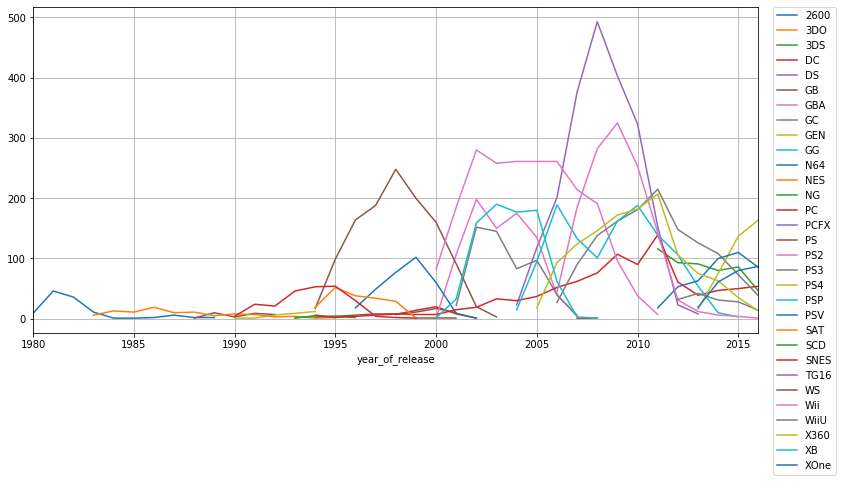

In [17]:
# график с количеством реализованных игр по платформам и годам релиза
ax = platforms_count_games.reset_index().plot(x='year_of_release', figsize=(13, 6), grid=True)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.show()

По приведенному графику уже можно предварительно сделать некие выводы.   

Например, почти по каждой платформе вначале идет рост количества реализованных игр, замем достигает некоторого максимума после чего происходит постепенное "затухание".
Период от начала продаж и до полного "затухания" можно назвать временем "жизни" платформы.  

Далее расчитаем среднее время жизни платформ и определим "актуальный" период анализа платформ. 

#### Платформы с наибольшими продажами

In [18]:
# all_sales - суммарные значения продаж по каждой платформе
all_sales = platforms_count_games.sum().sort_values(ascending=False)

all_sales.to_frame().T

platform,PS2,DS,PS3,Wii,X360,PSP,PS,PC,GBA,XB,GC,3DS,PSV,PS4,N64,XOne,SNES,SAT,WiiU,2600,NES,GB,DC,GEN,NG,SCD,WS,3DO,TG16,PCFX,GG
0,2134.0,2122.0,1306.0,1286.0,1234.0,1195.0,1190.0,958.0,811.0,806.0,543.0,512.0,429.0,392.0,316.0,247.0,239.0,173.0,147.0,116.0,98.0,97.0,52.0,29.0,12.0,6.0,6.0,3.0,2.0,1.0,1.0


In [19]:
all_sales.describe()

count      31.000000
mean      531.064516
std       618.218566
min         1.000000
25%        40.500000
50%       247.000000
75%       884.500000
max      2134.000000
dtype: float64

В качестве крупнейших возьмем все платформы, количесво продаж у которых более $Q_.75$.

In [20]:
big_platforms = all_sales[all_sales > all_sales.quantile(.75)]
big_platforms

platform
PS2     2134.0
DS      2122.0
PS3     1306.0
Wii     1286.0
X360    1234.0
PSP     1195.0
PS      1190.0
PC       958.0
dtype: float64

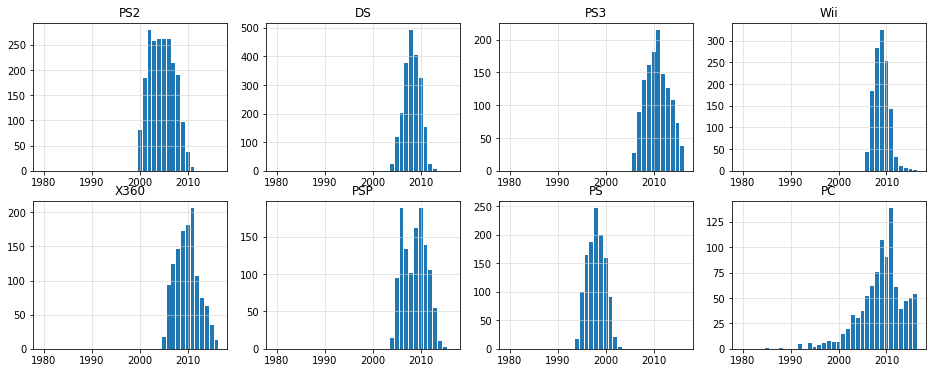

In [21]:
# графики количества реализованных игр по крупнейшим платформам
fig, ax = plt.subplots(2, 4, figsize=(16, 6))

for k, val in enumerate(big_platforms.index):
    i = k // 4
    j = k % 4
    ax[i, j].grid(color='lightgray', alpha=0.7)
    ax[i, j].bar(platforms_count_games.index, platforms_count_games.fillna(0)[val])
    ax[i, j].axes.set_title(val)
plt.show()    

На основании графиков можно сделать предположение, что большинство платформ живет около 10 лет.   

Затем им на смену приходят новые, основанные на более современных технологиях. Особенно это заментно по платформам PlayStation (PS*).  

Попробуем найти подтверждение нашему предположению.  
Для этого для каждой платформы посчитаем срок ее "жизни" - разницу между последним годом продажи и первым.


In [22]:
# duration - это таблица с начальным и конечным годом продаж, а также разницей между ними
duration = df.query('year_of_release > 0').groupby('platform')['year_of_release'].first().to_frame()
duration.columns = ['first_year']
duration['last_year'] = df.query('year_of_release > 0').groupby('platform')['year_of_release'].last()
duration['long'] = duration['last_year'] - duration['first_year'] + 1

duration.T

platform,2600,3DO,3DS,DC,DS,GB,GBA,GC,GEN,GG,N64,NES,NG,PC,PCFX,PS,PS2,PS3,PS4,PSP,PSV,SAT,SCD,SNES,TG16,WS,Wii,WiiU,X360,XB,XOne
first_year,1980,1994,2011,1998,1985,1988,2000,2001,1990,1992,1996,1983,1993,1985,1996,1994,2000,2006,2013,2004,2011,1994,1993,1990,1995,1999,2006,2012,2005,2000,2013
last_year,1989,1995,2016,2008,2013,2001,2007,2007,1994,1992,2002,1994,1996,2016,1996,2003,2011,2016,2016,2015,2016,1999,1994,1999,1995,2001,2016,2016,2016,2008,2016
long,10,2,6,11,29,14,8,7,5,1,7,12,4,32,1,10,12,11,4,12,6,6,2,10,1,3,11,5,12,9,4


In [23]:
duration.long.describe()

count    31.000000
mean      8.612903
std       6.998464
min       1.000000
25%       4.000000
50%       7.000000
75%      11.000000
max      32.000000
Name: long, dtype: float64

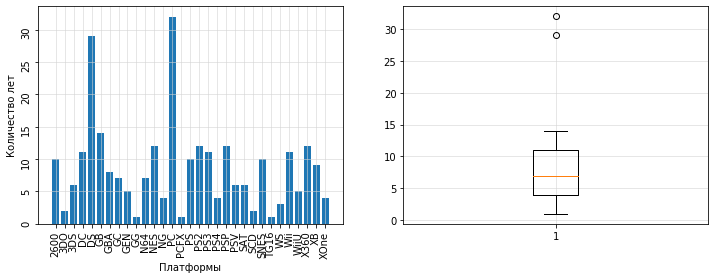

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].grid(color='lightgray', alpha=0.7)
ax[0].bar(duration.index, duration.long)
ax[0].tick_params(rotation=90)
ax[0].set_xlabel('Платформы')
ax[0].set_ylabel('Количество лет')
ax[1].grid(color='lightgray', alpha=0.7)
ax[1].boxplot(duration.long);

Получился достаточно большой разброс и есть явные "выбросы".  
Исключим из анализа крайние значения - 1 и 32 ('PC', 'GG', 'PCFX', 'TG16').  
Еще одни "выброс" на 29 (платформа DS), но там первая продажа обозначена 1985 годом, а все прочие - с 2004 г. В этом случае достаточно исключить только первое значение и все пересчитать заново.

In [25]:
duration.loc['DS', 'first_year'] = 2004
duration.loc['DS', 'long'] = 2013 - 2004 + 1
duration.drop(index=['PC', 'GG', 'PCFX', 'TG16'], inplace=True)
duration.long.describe()

count    27.000000
mean      7.888889
std       3.511885
min       2.000000
25%       5.000000
50%       8.000000
75%      11.000000
max      14.000000
Name: long, dtype: float64

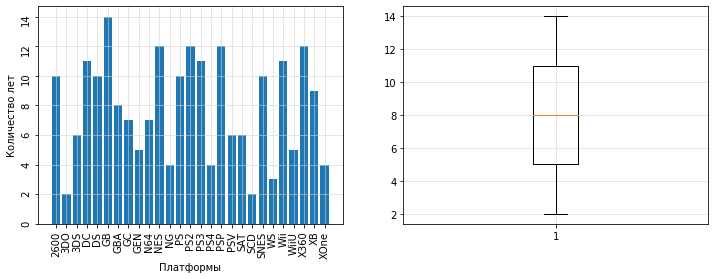

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].grid(color='lightgray', alpha=0.7)
ax[0].bar(duration.index, duration.long)
ax[0].tick_params(rotation=90)
ax[0].set_xlabel('Платформы')
ax[0].set_ylabel('Количество лет')
ax[1].grid(color='lightgray', alpha=0.7)
ax[1].boxplot(duration.long);

Таким образом, разброс стал намного меньше (данные получились более "плотными"), а медиана почти совпадает со средним значением.  
Наше предположение о том, что "характерная длительность жизни платформы составляет почти 10 лет", считаю верным.  

___На этом основании примем актуальный период анализа 10 лет.___
***

Теперь рассмотрим те платформы, по которым были продажи за последние 10 лет (актуальный период), и определим среди них потенциально прибыльные.

In [27]:
# platforms_last_10 - таблица с названиями платформ, которые имели продажи в последние 10 лет
platforms_last_10 = platforms_count_games.loc[2007:].sum()
platforms_last_10 = platforms_last_10[platforms_last_10 > 0].astype('int')
platforms_last_10.to_frame().T

platform,3DS,DC,DS,GBA,GC,PC,PS2,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XB,XOne
0,512,2,1779,6,4,725,546,1279,392,896,429,1242,147,1123,4,247


In [28]:
# platforms_actual - данные о количестве продаж по годам только по платформам, которые попали в platforms_last_10
platforms_actual = platforms_count_games.loc[2007:, [col for col in platforms_last_10.index]]
platforms_actual.fillna(0)

platform,3DS,DC,DS,GBA,GC,PC,PS2,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XB,XOne
year_of_release,,,,,,,,,,,,,,,,
2007,0.0,1.0,376.0,6.0,4.0,62.0,214.0,90.0,0.0,133.0,0.0,185.0,0.0,124.0,3.0,0.0
2008,0.0,1.0,493.0,0.0,0.0,76.0,191.0,138.0,0.0,101.0,0.0,282.0,0.0,146.0,1.0,0.0
2009,0.0,0.0,403.0,0.0,0.0,107.0,96.0,162.0,0.0,162.0,0.0,325.0,0.0,172.0,0.0,0.0
2010,0.0,0.0,323.0,0.0,0.0,90.0,38.0,181.0,0.0,188.0,0.0,253.0,0.0,182.0,0.0,0.0
2011,116.0,0.0,153.0,0.0,0.0,139.0,7.0,215.0,0.0,139.0,18.0,143.0,0.0,207.0,0.0,0.0
2012,93.0,0.0,23.0,0.0,0.0,61.0,0.0,148.0,0.0,106.0,53.0,31.0,32.0,106.0,0.0,0.0
2013,91.0,0.0,8.0,0.0,0.0,39.0,0.0,126.0,16.0,54.0,63.0,12.0,42.0,75.0,0.0,19.0
2014,80.0,0.0,0.0,0.0,0.0,47.0,0.0,108.0,75.0,10.0,100.0,6.0,31.0,63.0,0.0,61.0
2015,86.0,0.0,0.0,0.0,0.0,50.0,0.0,73.0,137.0,3.0,110.0,4.0,28.0,35.0,0.0,80.0


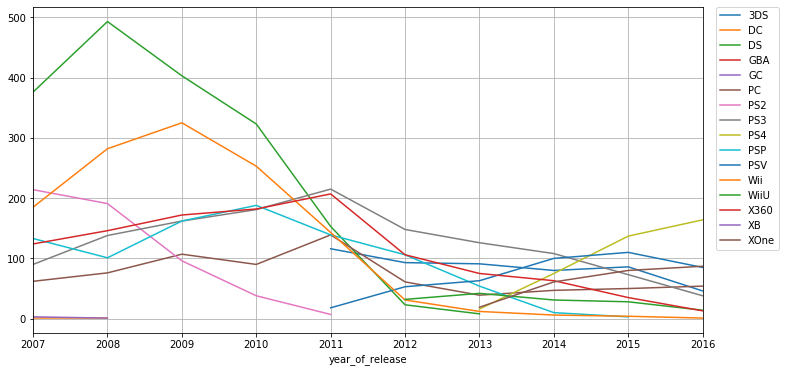

In [29]:
ax2 = platforms_actual.plot(grid=True, figsize=(12, 6))
ax2.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.show()

В получившейся таблице и графике сразу видно платформы, которые очевидно "затухают" (DC, DS, GBA, GC, PS2, Wii, XB), и их смело можно удалить из таблицы.

In [30]:
platforms_actual.drop(['DC', 'DS', 'GBA', 'GC', 'PS2', 'PSP', 'Wii', 'XB'], axis=1, inplace=True)
platforms_actual.fillna(0)

platform,3DS,PC,PS3,PS4,PSV,WiiU,X360,XOne
year_of_release,,,,,,,,
2007,0.0,62.0,90.0,0.0,0.0,0.0,124.0,0.0
2008,0.0,76.0,138.0,0.0,0.0,0.0,146.0,0.0
2009,0.0,107.0,162.0,0.0,0.0,0.0,172.0,0.0
2010,0.0,90.0,181.0,0.0,0.0,0.0,182.0,0.0
2011,116.0,139.0,215.0,0.0,18.0,0.0,207.0,0.0
2012,93.0,61.0,148.0,0.0,53.0,32.0,106.0,0.0
2013,91.0,39.0,126.0,16.0,63.0,42.0,75.0,19.0
2014,80.0,47.0,108.0,75.0,100.0,31.0,63.0,61.0
2015,86.0,50.0,73.0,137.0,110.0,28.0,35.0,80.0


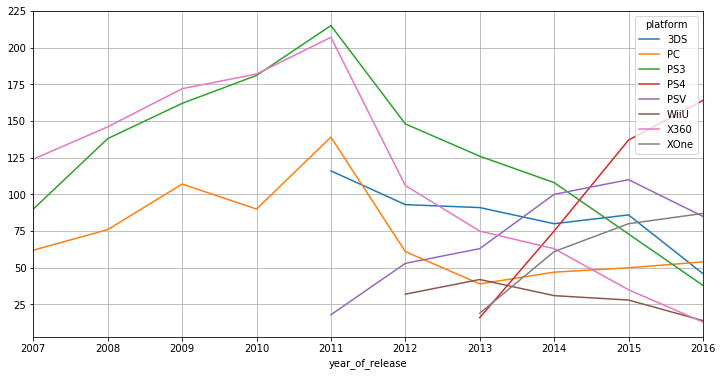

In [31]:
# диаграмма по количеству продаваемых игр актуальных платформ
platforms_actual.plot(grid=True, figsize=(12, 6))

Чтобы убедиться, какие платформы идут на спад по продажам, построим аппроксимирующие линии для каждой платформы.

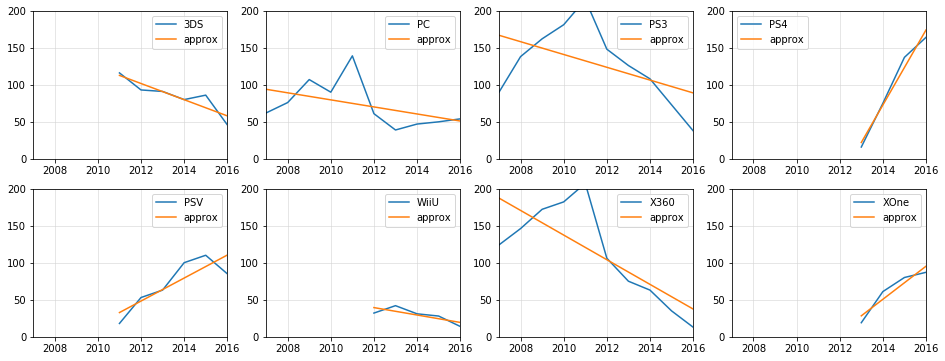

In [32]:
fig, ax = plt.subplots(2, 4, figsize=(16, 6))

for k, val in enumerate(platforms_actual.columns):
    platform = platforms_actual[val].dropna().to_frame()
    x = platform.index
    y = platform[val]
    p = np.polyfit(x, y, 1)  # вычисление коэффициентов многочлена

    i = k // 4
    j = k % 4
    ax[i, j].grid(color='lightgray', alpha=0.7)
    ax[i, j].plot(x, y, label=val)
    ax[i, j].plot(x, np.polyval(p, x), label='approx')
    ax[i, j].legend(loc='best')
    ax[i, j].set_xlim(2007, 2016)
    ax[i, j].set_ylim(0, 200)
    
plt.show()    

Видно, что на текущий год по количеству продаж лидирует платформа PS4. Эта платформа появилась только в 2012 г. и с тех пор постоянно растет. На пик продаж должна выйти только через 3-5 лет.  

Помимо этой платформы рост количества реализованных игр наблюдается у платформы XOne.  
Также рост за последние 5 лет происходил у PSV, но за последний год наблюдается спад. Вожможно это из-за того, что данные 2016г. не полные.  

Достаточно стабильными можно считать продажи у платформ PC и WiiU, хотя присутствует тренд на снижение.  

У остальных платформ прослеживается значительная тенденция к понижению продаж.  

**Итого, к потенциально прибыльным платформам можно отнести: PS3, XOne, PSV, PC и WiiU.**
***

#### График "ящик с усами" по количеству реализованных игр для актуальных платформ

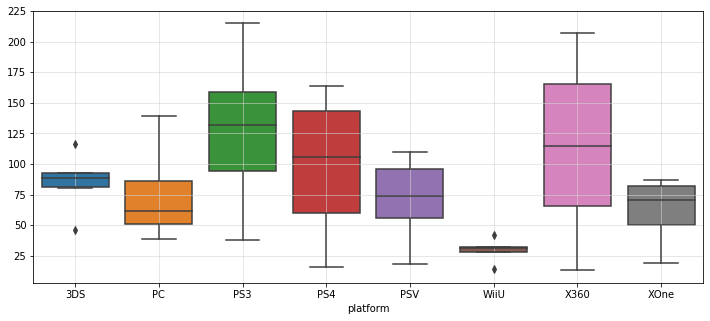

In [33]:
plt.figure(figsize=(12, 5))
boxplt2 = sns.boxplot(data=platforms_actual)
boxplt2.grid(color='lightgray', alpha=0.7)
plt.show()


Сами же статистические показатели по каждой платформе приведены в таблице ниже.

In [34]:
platforms_sales = df.pivot_table(index='year_of_release', columns='platform', 
                                 values='name', aggfunc='count')

platforms_stats = platforms_sales.describe().T
platforms_stats = platforms_stats.loc[[x for x in platforms_actual.columns]]

platforms_stats['sum'] = platforms_sales.sum()
platforms_stats

,count,mean,std,min,25%,50%,75%,max,sum
platform,,,,,,,,,
3DS,7.0,74.285714,35.901320,8.0,63.00,86.0,92.00,116.0,520.0
PC,27.0,36.074074,35.844671,1.0,6.50,30.0,53.00,139.0,974.0
PS3,12.0,110.916667,62.022662,25.0,64.25,117.0,151.50,215.0,1331.0
PS4,4.0,98.000000,66.156380,16.0,60.25,106.0,143.75,164.0,392.0
PSV,7.0,61.428571,40.852814,1.0,35.50,63.0,92.50,110.0,430.0
WiiU,5.0,29.400000,10.089599,14.0,28.00,31.0,32.00,42.0,147.0
X360,13.0,97.076923,65.649907,13.0,35.00,93.0,146.00,207.0,1262.0
XOne,4.0,61.750000,30.543685,19.0,50.50,70.5,81.75,87.0,247.0


Теперь давайте разберем полученные результаты.  

Всего было обнаружен 8 актуальных платформ.  

Платформы имеют совершенно разный уровень "успешности" (или привлекательности у геймеров).  
Так максимальные продажи в год очень разнятся от платформы к платформе - от 42 (WiiU) до 215 (PS3)!  
Также, как и средние продажи - от 29 до 111.  

Очень выделяются по показателям такие гиганты, как как PS3 и X360. Но ранее по графикам мы уже видели, что это "затухающие" платформы. Производители этих платформ выводят их из обслуживания. А на смену им уже пришли другие платформы от тех же производителей - PS4 и XOne соответственно.  

Среди тех платформ, которые мы отнесли к потенциально-прибыльным, особо выделяется PS4 - он значительно опережает конкурентов.  

***


#### Влияние на продажи внутри одной популярной платформы отзывы пользователей и критиков

Возьмем в качестве популярной платформы ту, у которой было больше всего продаж - PS2.

In [68]:
# анализ влияния на продажи отзывов критиков

ps2 = df.query('platform == "PS2" ').query('~critic_score.isna()')
ps2.critic_score = ps2.critic_score.astype('int')

In [69]:
ps2.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_all
1840,Rock Band,PS2,0,Misc,0.71,0.06,0.00,0.35,82,6.8,T,1.12
2108,Suikoden III,PS2,0,Role-Playing,0.29,0.23,0.38,0.08,86,7.7,T,0.98
2492,MLB SlugFest 20-03,PS2,0,Sports,0.41,0.32,0.00,0.11,77,8.2,E,0.84
3459,NASCAR: Dirt to Daytona,PS2,0,Racing,0.28,0.22,0.00,0.07,84,8.8,E,0.57
4848,Harvest Moon: Save the Homeland,PS2,0,Simulation,0.19,0.15,0.00,0.05,76,8.8,E,0.39


In [70]:
ps2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1298 entries, 1840 to 3408
Data columns (total 12 columns):
name               1298 non-null object
platform           1298 non-null object
year_of_release    1298 non-null int64
genre              1298 non-null object
na_sales           1298 non-null float64
eu_sales           1298 non-null float64
jp_sales           1298 non-null float64
other_sales        1298 non-null float64
critic_score       1298 non-null int64
user_score         1298 non-null object
rating             1298 non-null object
sales_all          1298 non-null float64
dtypes: float64(5), int64(2), object(5)
memory usage: 131.8+ KB


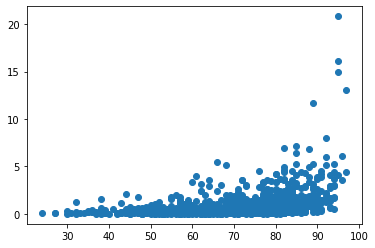

In [71]:
plt.scatter(ps2['critic_score'], ps2['sales_all']);

In [72]:
ps2.sales_all.corr(ps2.critic_score)

0.3954345494545488

___Значение 0.4 говорит о достаточно слабой зависимости количества реализованных игр от отзвов критиков.___
***

In [73]:
# анализ влияния на продажи отзывов пользователей

ps2_user_responses = df.query('platform == "PS2" ').query('~user_score.isna()')

ps2_user_responses.user_score.unique()

array(['6.8', '7.7', 'tbd', '8.2', '8.8', '6.9', '7.3', '8.5', '6.5',
       '8.6', '9.1', '3.2', '7.6', '7.8', '8.3', '8.9', '8', '8.1', '8.4',
       '7.9', '6.6', '6.3', '8.7', '5.8', '5.3', '6', '4.6', '5.9', '7.4',
       '7.5', '7.1', '3.3', '6.7', '7', '5.7', '4.9', '3.4', '7.2', '4',
       '9', '4.5', '3.9', '6.4', '3.5', '3.8', '6.2', '5.6', '5.5', '4.1',
       '5', '5.1', '9.3', '3', '6.1', '4.8', '5.2', '9.2', '4.4', '3.6',
       '3.1', '3.7', '4.3', '9.5', '4.7', '4.2', '5.4', '2.1', '2', '2.9',
       '1.7', '2.6', '2.3'], dtype=object)

Поскольку значение 'tbd' - это неопределенное значение, то исключим записи с таким значением.

In [74]:
ps2_user_responses = ps2_user_responses.query('~(user_score == "tbd")')
ps2_user_responses.user_score = ps2_user_responses.user_score.astype('float')
ps2_user_responses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1241 entries, 1840 to 12525
Data columns (total 12 columns):
name               1241 non-null object
platform           1241 non-null object
year_of_release    1241 non-null int64
genre              1241 non-null object
na_sales           1241 non-null float64
eu_sales           1241 non-null float64
jp_sales           1241 non-null float64
other_sales        1241 non-null float64
critic_score       1161 non-null float64
user_score         1241 non-null float64
rating             1241 non-null object
sales_all          1241 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 126.0+ KB


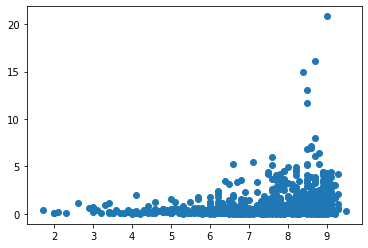

In [75]:
plt.scatter(ps2_user_responses['user_score'], ps2_user_responses['sales_all']);

In [76]:
ps2_user_responses.sales_all.corr(ps2_user_responses.user_score)

0.17286551112058177

___Как ни странно, отзывы игроков еще меньше меньше влияют на продажи (практически, вообще не влияют).___

#### Вывод:

Анализ самой популярной платформы показал, что продажи игр данной платформы в почти не зависит от мнения экспертов, а отзывы игроков вообще никак не влияют.  

Попробуем проверить данный вывод на платформах, которые вошли в наш ТОП-листинг (big_platforms).

In [44]:
# анализ влияния мнения критиков

df_big_critic = df.query('~critic_score.isna() & (platform in @big_platforms.index)')
df_big_critic.platform.unique()

array(['DS', 'PC', 'PS', 'PS2', 'PS3', 'PSP', 'Wii', 'X360'], dtype=object)

In [77]:
pt = (
    df_big_critic
    .pivot_table(index=df_big_critic.index, columns='platform', 
                 values='critic_score', aggfunc='first')
)
pt['sales_all'] = df.sales_all
pt.fillna('').head()

platform,DS,PC,PS,PS2,PS3,PSP,Wii,X360,sales_all
0,,,,,,,76,,82.54
2,,,,,,,82,,35.52
3,,,,,,,80,,32.77
6,89,,,,,,,,29.80
7,,,,,,,58,,28.91


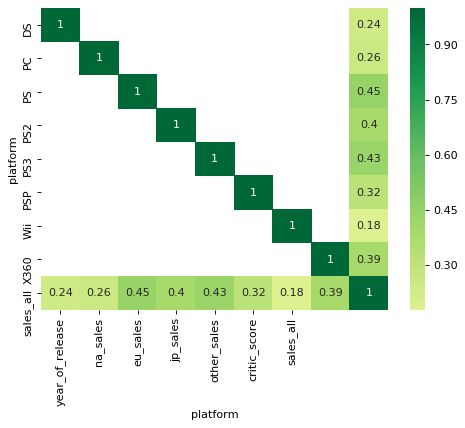

In [87]:
plt.figure(figsize=(7,5), dpi= 80)
sns.heatmap(pt.corr(), xticklabels=df.corr().columns, yticklabels=pt.corr().columns, cmap='RdYlGn', center=0, annot=True)
plt.show()

**Таким образом, почти для всех крупных платформ подверждается предположение о том, что мнение критиков достаточно слабо влияет, а то и вообще не влияет на продажи игр.**

In [48]:
# анализ влияния мнения игроков

df_big_user = df.query('(platform in @big_platforms.index)').query('~(user_score.isna() | (user_score == "tbd"))')
df_big_user.platform.unique()

array(['DS', 'PC', 'PS', 'PS2', 'PS3', 'PSP', 'Wii', 'X360'], dtype=object)

In [85]:
pt2 = (
    df_big_user
    .pivot_table(index=df_big_user.index, columns='platform', 
                 values='user_score', aggfunc='first')
).astype('float')
pt2['sales_all'] = df.sales_all

pt2.fillna('').head()

platform,DS,PC,PS,PS2,PS3,PSP,Wii,X360,sales_all
0,,,,,,,8,,82.54
2,,,,,,,8.3,,35.52
3,,,,,,,8,,32.77
6,8.5,,,,,,,,29.80
7,,,,,,,6.6,,28.91


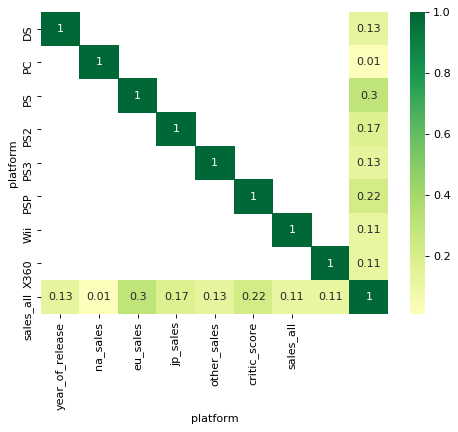

In [86]:
plt.figure(figsize=(7,5), dpi= 80)
sns.heatmap(pt2.corr(), xticklabels=df.corr().columns, yticklabels=pt2.corr().columns, cmap='RdYlGn', center=0, annot=True)
plt.show()

**Как и в случае с платформой PS2 количество реализованных игр всех крупных платформ на зависят от отзывов пользователей игр.**
***

### Распределение игр по жанрам

In [106]:
genre_pt = (
    df
     .pivot_table(index='genre', values='sales_all', aggfunc=['count', 'sum'])
     .set_axis(['count_sales', 'sum_sales'], axis=1, inplace=False)
     .sort_values(by='sum_sales', ascending=False)
)

genre_pt

,count_sales,sum_sales
genre,,
Action,3369,1744.17
Sports,2348,1331.27
Shooter,1323,1052.45
Role-Playing,1498,934.56
Platform,888,827.77
Misc,1750,802.51
Racing,1249,728.67
Fighting,849,447.53
Simulation,873,389.97


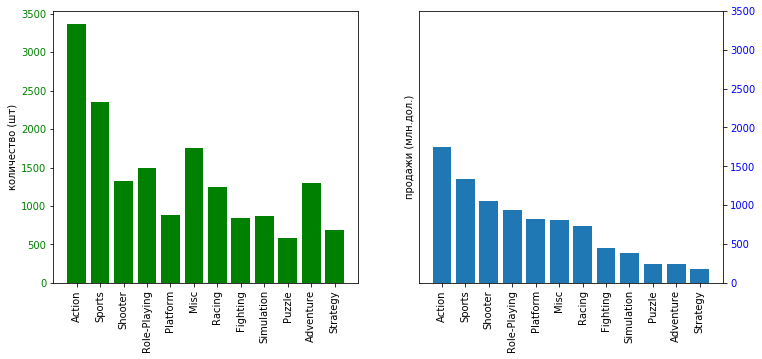

In [115]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].bar(genre_pt.index, genre_pt.count_sales, color='green')
ax[0].tick_params(axis='x', rotation=90)
ax[0].tick_params(axis='y', labelcolor='green')
ax[0].set_ylabel('количество (шт)')


ax[1].bar(genre_pt.index, genre_pt.sum_sales)
ax[1].tick_params(axis='x', rotation=90)
ax[1].tick_params(axis='y', labelcolor='blue')
ax[1].yaxis.tick_right()
ax[1].set_ylabel('продажи (млн.дол.)')
ax[1].set_ylim(0, 3500)
plt.show();

Самым продаваемым оказался жанр Action (это жанр, в котором делается упор на эксплуатацию физических возможностей игрока, в том числе координации глаз и рук и скорости реакции). В пятерку вошли еще 2 жанра, которые являются подвидами жанра Action - это Shooter (различные "стрелялки") и Platform (бег по платформам или уровням).  

На втором месте находится жанр Sports - это симуляторы спортивных игр: футбол, теннис, бильярд и т.д.  

На четвертом жанр Role-Playing (RPG) - это ролевые игры, к которым относятся такие известные игры, как WordOfWarcraft, Dota2 и др.

Что бросается в глаза, так это то, что объем доходов самого высоко продаваемого жанра превосходит объем самого низко продаваемого почти в 10 раз.  
***

# Шаг 4. Составление портрета пользователя каждого региона

#### Самые популярные платформы (ТОП-5)

In [53]:

df_with_region = (
    df
    .sort_index()
    .loc[:, ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']]
    .set_axis(['na', 'eu', 'jp', 'other'], axis=1, inplace=False)
    .stack()
    .reset_index()
    .set_axis(['df_index', 'region', 'sales'], axis=1, inplace=False)
)
df_with_region.head()

,df_index,region,sales
0,0,na,41.36
1,0,eu,28.96
2,0,jp,3.77
3,0,other,8.45
4,1,na,29.08


In [54]:
regions_platform = (
    df_with_region
    .join(df, on='df_index')
    .pivot_table(index=['platform'], columns='region', values='sales', 
                 aggfunc=['sum'])
)
regions_platform.columns = [b for (a, b) in regions_platform.columns]
regions_platform.head()

,eu,jp,na,other
platform,,,,
2600,5.47,0.00,90.60,0.91
3DO,0.00,0.10,0.00,0.00
3DS,61.48,100.67,83.49,13.36
DC,1.69,8.56,5.43,0.27
DS,188.89,175.57,382.40,59.26


In [55]:
def get_top_5(col, col_name):
    sum_all = col.sum()
    kind = col.index.name
    top5 = []
    s = 0
    for i in range(5):
        item = col[col == col.max()]
        for k,l in item.items():
            s += l
            top5.append([k, l])
            pp = col.pop(k)
    top5.append(['top5', s])
    top5.append(['all', sum_all])
    top5_df = pd.DataFrame(top5)
    top5_df.columns = [col_name + '_' + kind, col_name + '_max']
    return top5_df

In [56]:
top5_platforms = pd.DataFrame(index=[i for i in range(7)])
for col in regions_platform.columns:
    top5_platforms = top5_platforms.join(get_top_5(regions_platform[col], col))
    top5_platforms[col+'_part'] = top5_platforms[col + '_max'] / top5_platforms.loc[6, col + '_max']
    
top5_platforms

,eu_platform,eu_max,eu_part,jp_platform,jp_max,jp_part,na_platform,na_max,na_part,other_platform,other_max,other_part
0,PS2,339.29,0.139932,DS,175.57,0.135328,X360,602.47,0.136852,PS2,193.44,0.244452
1,PS3,330.29,0.136221,PS,139.82,0.107772,PS2,583.84,0.132620,PS3,135.68,0.171460
2,X360,270.76,0.111669,PS2,139.20,0.107294,Wii,496.90,0.112872,X360,85.76,0.108376
3,Wii,262.21,0.108143,SNES,116.55,0.089836,PS3,393.49,0.089382,Wii,79.07,0.099922
4,PS,213.61,0.088099,3DS,100.67,0.077595,DS,382.40,0.086863,DS,59.26,0.074888
5,top5,1416.16,0.584063,top5,671.81,0.517825,top5,2459.10,0.558588,top5,553.21,0.699098
6,all,2424.67,1.000000,all,1297.37,1.000000,all,4402.35,1.000000,all,791.32,1.000000


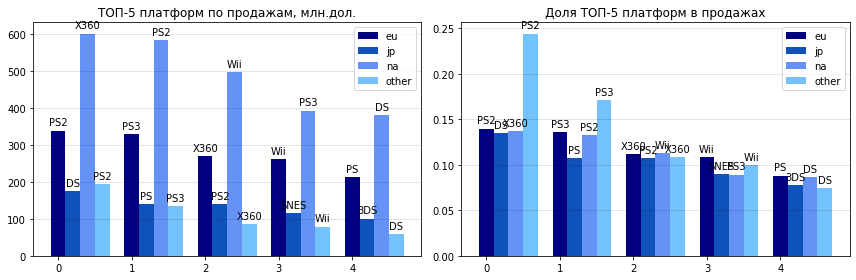

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
width = 0.2

def autolabel(ax_, rects, reg_name):
    lables = top5_platforms[reg_name + '_platform'].values[:5]
    for i, rect in enumerate(rects):
        height = rect.get_height()
        ax_.annotate(lables[i], 
                     xy=(rect.get_x() + rect.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

x = top5_platforms.index[:5]
colors = ['#000080','#0F52BA','#6593F5','#73C2FB']
for i in range(4):
    reg_name = regions_platform.columns[i]
    rects = ax[0].bar(x + i * width, top5_platforms[reg_name + '_max'].values[:5], width, 
                     color=colors[i], label=reg_name)
    autolabel(ax[0], rects, reg_name)
    rects = ax[1].bar(x + i * width, top5_platforms[reg_name + '_part'].values[:5], width, 
                     color=colors[i], label=reg_name)
    autolabel(ax[1], rects, reg_name)

    
ax[0].legend()
ax[0].set_title('ТОП-5 платформ по продажам, млн.дол.')
ax[0].grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
ax[1].legend()
ax[1].set_title('Доля ТОП-5 платформ в продажах')
ax[1].grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)


fig.tight_layout()
plt.show()

В последней таблице были приведены ТОП-5 платформ по каждому региону в порядке убывания их продаж, сумма их продаж и доля их продаж к общей сумме продаж по региону.  

Обращает на себя внимание популярность платформ PlayStation разных поколений - вовсех регионах они занимают 1-2 места.  

Если же рассматривать по-регионно, то в Северной Америке лидером стала X360 - это продукт от Microsoft. Совсем немного от нее отстала PlayStation2. Доли их в продажах по этому региону почти совпадают и составляют около 13,5%. 

На Европейском рынке лидируют продукты PlayStation второго и третьего поколений (доли их составляют около 14%). Они с большим запасом оторвались от третьего места - платформы X360 (11%).  

В Японии предпочитают продукты местного производства и лидером здесь стала платформа от Nintendo - DS (13,5%), на втором и третьем местах расположились PS и PS2 (почти по 11%).

Рынок прочих регионов не такой информативный - его доля в целом по миру составляет менее 9%. Лидирует здесь с очень большим отрывом PS2 (24.5%). На втором месте тоже продукт PlayStation - PS3 (17%). На третьем - продукт от Microsoft - X360 (почти 11%).

Примечательно, что в первых трех регионах продажи лидеров рынка составляют 13-14% от продаж в целом по региону.
***

#### Самые популярные жанры (топ-5)

In [58]:
regions_genre = (
    df_with_region
    .join(df, on='df_index')
    .pivot_table(index=['genre'], columns='region', values='sales', aggfunc=['sum'])
)
regions_genre.columns = [b for (a, b) in regions_genre.columns]

regions_genre

,eu,jp,na,other
genre,,,,
Action,519.13,161.43,879.01,184.60
Adventure,63.54,52.30,105.26,16.49
Fighting,100.33,87.48,223.36,36.36
Misc,212.74,108.11,407.27,74.39
Platform,200.35,130.83,445.50,51.09
Puzzle,50.01,57.31,122.87,12.38
Racing,236.51,56.71,359.35,76.10
Role-Playing,188.71,355.41,330.81,59.63
Shooter,317.34,38.76,592.24,104.11


In [59]:
top5_genres = pd.DataFrame(index=[i for i in range(7)])
for col in regions_platform.columns:
    top5_genres = top5_genres.join(get_top_5(regions_genre[col], col))
    top5_genres[col+'_part'] = top5_genres[col + '_max'] / top5_genres.loc[6, col + '_max']
    
top5_genres

,eu_genre,eu_max,eu_part,jp_genre,jp_max,jp_part,na_genre,na_max,na_part,other_genre,other_max,other_part
0,Action,519.13,0.214150,Role-Playing,355.41,0.273953,Action,879.01,0.199749,Action,184.60,0.233305
1,Sports,376.79,0.155432,Action,161.43,0.124432,Sports,684.43,0.155532,Sports,134.51,0.169999
2,Shooter,317.34,0.130908,Sports,135.54,0.104475,Shooter,592.24,0.134583,Shooter,104.11,0.131578
3,Racing,236.51,0.097564,Platform,130.83,0.100845,Platform,445.50,0.101237,Racing,76.10,0.096178
4,Misc,212.74,0.087759,Misc,108.11,0.083332,Misc,407.27,0.092549,Misc,74.39,0.094017
5,top5,1662.51,0.685814,top5,891.32,0.687037,top5,3008.45,0.683650,top5,573.71,0.725077
6,all,2424.14,1.000000,all,1297.34,1.000000,all,4400.57,1.000000,all,791.24,1.000000


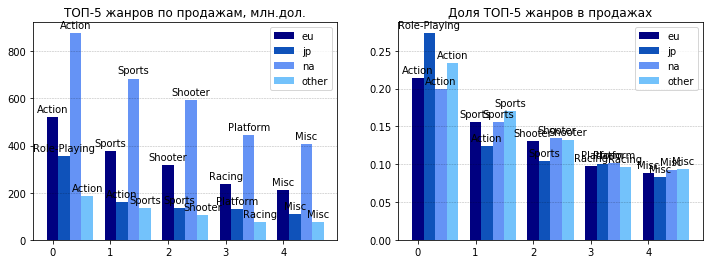

In [123]:
fig2, ax2 = plt.subplots(1, 2, figsize=(12, 4))
width = 0.2

def autolabel2(ax_, rects, reg_name):
    lables = top5_genres[reg_name + '_genre'].values[:5]
    for i, rect in enumerate(rects):
        height = rect.get_height()
        ax_.annotate(lables[i], 
                     xy=(rect.get_x() + rect.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

x = top5_genres.index[:5]
for i in range(4):
    reg_name = regions_platform.columns[i]
    rects = ax2[0].bar(x + i * width, top5_genres[reg_name + '_max'].values[:5], width, 
                      color=colors[i], label=reg_name)
    autolabel2(ax2[0], rects, reg_name)
    rects = ax2[1].bar(x + i * width, top5_genres[reg_name + '_part'].values[:5], width, 
                     color=colors[i], label=reg_name)
    autolabel2(ax2[1], rects, reg_name)

    
ax2[0].legend()
ax2[0].set_title('ТОП-5 жанров по продажам, млн.дол.')
ax2[0].grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
ax2[1].legend()
ax2[1].set_title('Доля ТОП-5 жанров в продажах')
ax2[1].grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)


fig.tight_layout()
plt.show()

Самыми популярными жанрами в трех регионах из четырех являются (в порядке убывания) Action, Sports и Shooter.  

И только в Японии на первом месте оказался жанр Role-Playing (там больше предпочитают ролевые игры), который в других регионах не вошел даже в тройку лидеров. Хотя второе и третье место там тоже заняли Action и Sports.  

Таким образом, предпочтения игроков по жанрам приблизительно одинаковые во всем мире.

Примечательно, что лидеры регионов занимиют 20% и выше от всех продаж в регионе и имеют очень большой отрыв от второго места.
***

#### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

Справка из Википедии по значениями классификации:  
* «EC» («Early childhood») — «Для детей младшего возраста»
* «E» («Everyone») — «Для всех»
* «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»
* «T» («Teen») — «Подросткам»
* «M» («Mature») — «Для взрослых»
* «AO» («Adults Only 18+») — «Только для взрослых»
* «RP» («Rating Pending») — «Рейтинг ожидается»
* K-A for Kids to Adults

In [61]:
# df_with_esrb - таблица с продажами и рейтингом (общая)

df_with_esrb = (
    df_with_region
    .join(df['rating'], on='df_index')
    .dropna()
)
df_with_esrb.head()

,df_index,region,sales,rating
0,0,na,41.36,E
1,0,eu,28.96,E
2,0,jp,3.77,E
3,0,other,8.45,E
8,2,na,15.68,E


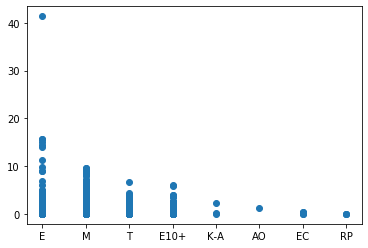

In [62]:
# вывод результата для региона Северная Америка
df_with_esrb_na = df_with_esrb.query('region == "na"')
plt.scatter(df_with_esrb_na['rating'], df_with_esrb_na['sales'])

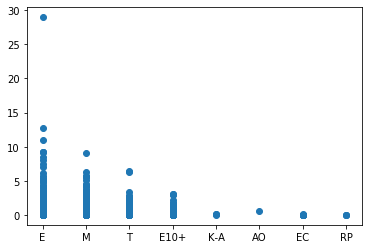

In [63]:
# вывод результата для региона Европа
df_with_esrb_na = df_with_esrb.query('region == "eu"')
plt.scatter(df_with_esrb_na['rating'], df_with_esrb_na['sales'])

На примере двух регионов видно, что рейтинг ESRB имеет сильное влияние на продажи в регионах. Так в Северной Америке и Европе наиболее продаваемые игры с оценкой E (для всех) и M (для взрослых).


#### Выводы

Анализируя ТОП-5 платформ по регионам, ТОП-5 жанров по регионам и рейтинги по версии ESRB, можем сделать следующие выводы:

* почти во всем мире, кроме Северной Америки, больше всего предпочитают игры на платформах японских компаний (PlayStation и Nintendo), а в Северной Америки больше отдают предпочтение американскому производителю - Microsoft (X360);

* что касается жанров, то здесь ситуация одинаковая почти для всего мира (за исключением Японии) - везде на первых местах жанры Action, Sports и Shooter. В Японии же на первом месте жанр Role-Playing (RPG) и только потом Action, Sports и Shooter;

* во всем мире наиболее популярны игры, которые имеют оценки E (для всех) и M (для взрослых) по версии ESRB.

Если же описать портрет среднего пользователя, то он: человек достаточно взрослый, любит игры активные, быстрые, где нужна физическая реакция.  
Но в Японии несколько другой тип пользователя - это тоже взрослый человек, но больше предпочитающий ролевые игры (по моему мнению, это характерно вообще для всей восточной Азии). 


# Шаг 5. Проверьте гипотезы

* Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;  
* Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные.

#### Проверка гипотезы: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

$𝐻_0$  = "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые"  
$𝐻_1$  = "Средние пользовательские рейтинги платформ Xbox One и PC различны"

Поскольку это случай проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, то будем применять односторонний критерий Сьюдента и функцию ttest_ind из библиотеки scipy.


In [117]:
# формирование таблицы с платформами и средними значениями пользовательских рейтингов по годам

df_with_scores = df.query('~(user_score == "tbd") & ~user_score.isna()')
df_with_scores.user_score = df_with_scores.user_score.astype('float')

avg_user_scores = (
    df_with_scores
    .pivot_table(index='year_of_release', columns='platform', values='user_score')
)
avg_user_scores.loc[:, ['PC', 'XOne']].tail()

platform,PC,XOne
year_of_release,,
2012,6.911765,NaN
2013,6.232353,5.811765
2014,6.302632,6.738636
2015,6.294872,6.474545
2016,6.297778,6.598485


In [121]:
print('Дисперсия данных по платформе PC:', avg_user_scores['PC'].var())
print('Дисперсия данных по платформе XOne:', avg_user_scores['XOne'].var())

Дисперсия данных по платформе PC: 1.9317458214271326
Дисперсия данных по платформе XOne: 0.16850378352969844


In [122]:
# поскольку дисперсии двух массивов существенно различаются, 
# то в функции st.ttest_ind зададим параметр equal_var = False

from scipy import stats as st

alpha = 0.05
pc_user_score = avg_user_scores['PC'].dropna()
xone_user_score = avg_user_scores['XOne'].dropna()

results = st.ttest_ind(pc_user_score, xone_user_score, equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.026913126761802932
Отвергаем нулевую гипотезу


Таким образом, мы отвергаем нулевую гипотезу. Т.е. средние рейтинги пользователей для указанных платформ различны.

#### Проверка гипотезы: Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные.

$𝐻_0$ = "Средние пользовательские рейтинги жанров Action и Sports одинаковые"  
$𝐻_1$ = "Средние пользовательские рейтинги жанров Action и Sports различны"

Поскольку это случай проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, то будем применять односторонний критерий Сьюдента и функцию ttest_ind из библиотеки scipy.

In [66]:
avg_user_scores2 = (
    df_with_scores
    .pivot_table(index='year_of_release', columns='genre', values='user_score')
)
avg_user_scores2.loc[:, ['Action', 'Sports']].tail()

genre,Action,Sports
year_of_release,,
2012,6.788806,6.451429
2013,7.101075,5.287879
2014,6.672115,5.273333
2015,6.941667,5.006667
2016,6.638824,5.432432


In [119]:
print('Дисперсия данных по жанру Action:', avg_user_scores2['Action'].var())
print('Дисперсия данных по жанру Sports:', avg_user_scores2['Sports'].var())

Дисперсия данных по жанру Action: 0.4599482285734865
Дисперсия данных по жанру Sports: 1.319339702019021


In [120]:
# поскольку дисперсии двух массивов существенно различаются, 
# то в функции st.ttest_ind зададим параметр equal_var = False

alpha = 0.05
action = avg_user_scores2['Action'].dropna()
sports = avg_user_scores2['Sports'].dropna()

results = st.ttest_ind(action, sports, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.26415156845642407
Не получилось отвергнуть нулевую гипотезу


Таким образом, мы не смогли принять гипотезу о различии средних рейтингов для указанных жанров, а значит считаем их равными.
***

# Шаг 6. Общий вывод


В результате анализа было обнаружено, что:

* актуальный период жизни игровых платформ около 10 лет. Затем им на смену приходят новые с более современными технологиями;

* выявлены потенциально-прибыльные платформы - это те, которые находятся не в конце "актуального" периода (жизненного цикла) и имеют рост продаж или стабильные продажи;

* наиболее продаваемыми жанрами оказались Action, Sports и Shooter;

* положительные мнения экспертов оказывают достаточно большую роль в продажах игр;

* если говорить о категориях, установленные ESRB, то наиболее продаваемые - это игры с категорией Е (для всех) и М (для взрослых).
